In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [2]:
Data=pd.read_csv("ONLINE_RETAILS.xlsx - Online Retail.csv")


# Data Preprocessing

In [3]:
#data preprocessing 
Data.dtypes
#Regulariser les type de chaque columns
Data["UnitPrice"] = [float(str(i).replace(",", "")) for i in Data["UnitPrice"]]
Data["CustomerID"] = Data["CustomerID"].fillna(0)

Data.InvoiceNo.astype(str)
Data.StockCode.astype(str)
Data.Description.astype(str)
Data['InvoiceDate'] = pd.to_datetime(Data['InvoiceDate'])


Data.UnitPrice.astype(float)
Data.CustomerID.astype(int)
Data.Country.astype(str)

0         United Kingdom
1         United Kingdom
2         United Kingdom
3         United Kingdom
4         United Kingdom
               ...      
541904            France
541905            France
541906            France
541907            France
541908            France
Name: Country, Length: 541909, dtype: object

In [4]:
#Strings
Data['Description'] = Data['Description'].str.replace('.','').str.upper().str.strip()
Data['Description'] = Data['Description'].replace('\s+',' ',regex = True)
Data['InvoiceNo'] = Data['InvoiceNo'].astype(str).str.upper()
Data['StockCode'] = Data['StockCode'].str.upper()
Data['Country'] = Data['Country'].str.upper()
Data.head()

<ipython-input-4-d96fd565efd7>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  Data['Description'] = Data['Description'].str.replace('.','').str.upper().str.strip()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,255.0,17850.0,UNITED KINGDOM
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,339.0,17850.0,UNITED KINGDOM
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,275.0,17850.0,UNITED KINGDOM
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,339.0,17850.0,UNITED KINGDOM
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART,6,2010-12-01 08:26:00,339.0,17850.0,UNITED KINGDOM


In [5]:

#Listing Some Irrelevant StockCodes
Irrelevant = Data['StockCode'].unique()
Irrelevant.sort()
print('Transactions non pertinentes: \n',Irrelevant[::-1][:4])
#Quantity and UnitPrice Summary
Data.describe().iloc[:,:2]

Transactions non pertinentes: 
 ['S' 'POST' 'PADS' 'M']


,Quantity,UnitPrice
count,541909.000000,5.419090e+05
mean,9.552250,4.084587e+02
std,218.081158,7.770606e+03
min,-80995.000000,-1.106206e+06
25%,1.000000,8.500000e+01
50%,3.000000,1.950000e+02
75%,10.000000,3.950000e+02
max,80995.000000,1.783646e+06


Comme il est évident dans le résumé de notre ensemble de données, nous avons des valeurs impaires et irrégulières dans les colonnes 'UnitPrice' et 'Quantity' que nous allons trouver et supprimer pour éviter qu'elles n'affectent négativement notre analyse. Dans la variable 'StockCode', nous pouvons voir que certaines des transactions ne sont pas réellement des produits, mais ce sont des coûts ou des frais concernant la poste ou la banque ou d'autres transactions dont nous n'avons pas vraiment besoin dans nos données.

In [6]:
import numpy as np, pandas as pd, re, scipy as sp, scipy.stats
#Outliers and Irrelevant Values
#Dropping all stockcodes that contain only strings
CodeTypes = list(map(lambda codes: any(char.isdigit() for char in codes), Data['StockCode']))
IrrelevantCodes = [i for i,v in enumerate(CodeTypes) if v == False]
Data.drop(IrrelevantCodes , inplace = True)
#Removing Outliers Based on Z-score
Data = Data[(np.abs(sp.stats.zscore(Data['UnitPrice']))<3) & (np.abs(sp.stats.zscore(Data['Quantity']))<5)]


Nous savons que certaines de ces transactions contiennent des produits retournés et dans ces transactions, le 'InvoiceNo' contient un caractère 'c' au début et le 'UnitPrice' doit avoir une valeur négative. Mais dans nos données, nous avons des achats qui ont un 'UnitPrice' négatif et vice versa et nous devons supprimer ces erreurs. Il existe également des touples dans lesquels le 'UnitPrice' n'est pas spécifié.

Dans l'attribut 'Description', il y a beaucoup de valeurs manquantes ou incorrectes. Afin de résoudre ce problème, nous supprimerons les transactions qui n'ont aucune description disponible et pour les autres valeurs manquantes, nous vérifierons la 'Description' basée sur le produit 'StockCode' et remplirons les valeurs manquantes avec la 'Description' correcte qui est disponible à partir des autres transactions du même 'StockCode'.

In [7]:
# Missing & Incorrect Values
Data.drop(Data[(Data.Quantity>0) & (Data.InvoiceNo.str.contains('C') == True)].index, inplace = True)
Data.drop(Data[(Data.Quantity<0) & (Data.InvoiceNo.str.contains('C') == False)].index, inplace = True)
Data.drop(Data[Data.Description.str.contains('?',regex=False) == True].index, inplace = True)
Data.drop(Data[Data.UnitPrice == 0].index, inplace = True)

for index,value in Data.StockCode[Data.Description.isna()==True].items():
    if pd.notna(Data.Description[Data.StockCode == value]).sum() != 0:
        Data.Description[index] = Data.Description[Data.StockCode == value].mode()[0]
    else:
        Data.drop(index = index, inplace = True)
        
Data['Description'] = Data['Description'].astype(str)

Dans cet ensemble de données, certaines lignes indiquent que les mêmes produits ont des 'UnitPrice' différents. Cela peut provenir du fait qu'il peut y avoir des remises sur certains produits ou des conditions spéciales pour des clients spécifiques. Nous pouvons également voir que pour le même client, nous avons deux prix différents sur deux jours différents ou des prix différents pour un client différent le même jour. Donc, pour les besoins de cette démonstration, nous supposons que ces valeurs sont incorrectes en raison d'erreurs de saisie ou d'erreurs humaines et pour chaque produit, nous utilisons la valeur de mode de son 'UnitPrice'.

In [8]:
#Incorrect Prices
StockList = Data.StockCode.unique()
CalculatedMode = map(lambda x: Data.UnitPrice[Data.StockCode == x].mode()[0],StockList)
StockModes = list(CalculatedMode)
for i,v in enumerate(StockList):
    Data.loc[Data['StockCode']== v, 'UnitPrice'] = StockModes[i]

Enfin, nous aimerions ajouter des fonctionnalités utiles pour une analyse future. Les fonctionnalités que nous ajouterons pour l'instant sont le prix final de chaque transaction et le mois et le jour de la semaine au cours desquels la transaction a eu lieu, que nous pouvons tirer de l'attribut 'InvoiceDate'.

Il existe également des identifiants client incorrects pour lesquels, pour deux pays différents, nous avons le même identifiant client. Nous corrigerons les valeurs en double en regroupant la trame de données par 'CustomerID' et si un client appartient à plus de deux pays, nous remplaçons la valeur incorrecte par la valeur de mode du pays du client.

In [9]:
#Customers with Different Countries
Customers = Data.groupby('CustomerID')['Country'].unique()
Customers.loc[Customers.apply(lambda x:len(x)>1)]

CustomerID
0.0        [UNITED KINGDOM, EIRE, BAHRAIN, ISRAEL, HONG K...
12370.0                                    [CYPRUS, AUSTRIA]
12394.0                                   [BELGIUM, DENMARK]
12417.0                                     [BELGIUM, SPAIN]
12422.0                             [AUSTRALIA, SWITZERLAND]
12429.0                                   [DENMARK, AUSTRIA]
12431.0                                 [AUSTRALIA, BELGIUM]
12455.0                                      [CYPRUS, SPAIN]
12457.0                                [SWITZERLAND, CYPRUS]
Name: Country, dtype: object

In [10]:
#Fixing Duplicate CustomerIDs
for i,v in Data.groupby('CustomerID')['Country'].unique().items():
    if len(v)>1:
        Data.Country[Data['CustomerID'] == i] = Data.Country[Data['CustomerID'] == i].mode()[0]

#Adding Desired Features
Data['FinalPrice'] = Data['Quantity']*Data['UnitPrice']
Data['InvoiceMonth'] = Data['InvoiceDate'].apply(lambda x: x.strftime('%B'))
Data['Day of week'] = Data['InvoiceDate'].dt.day_name()


<ipython-input-10-71485b1c6be3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data.Country[Data['CustomerID'] == i] = Data.Country[Data['CustomerID'] == i].mode()[0]
<ipython-input-10-71485b1c6be3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data.Country[Data['CustomerID'] == i] = Data.Country[Data['CustomerID'] == i].mode()[0]
<ipython-input-10-71485b1c6be3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data.Country[Data['C

In [11]:
Data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FinalPrice,InvoiceMonth,Day of week
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,295.0,17850.0,UNITED KINGDOM,1770.0,December,Wednesday
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,375.0,17850.0,UNITED KINGDOM,2250.0,December,Wednesday
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,415.0,17850.0,UNITED KINGDOM,3320.0,December,Wednesday
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,375.0,17850.0,UNITED KINGDOM,2250.0,December,Wednesday
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART,6,2010-12-01 08:26:00,425.0,17850.0,UNITED KINGDOM,2550.0,December,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,85.0,12680.0,FRANCE,1020.0,December,Friday
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,21.0,12680.0,FRANCE,126.0,December,Friday
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,415.0,12680.0,FRANCE,1660.0,December,Friday
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,415.0,12680.0,FRANCE,1660.0,December,Friday


In [12]:
# Question 1: produits un client achète-t-il généralement
Data["Quantity"].mean()

9.778979795716038

In [13]:
#importing necessary libraries and the cleaned dataset
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline


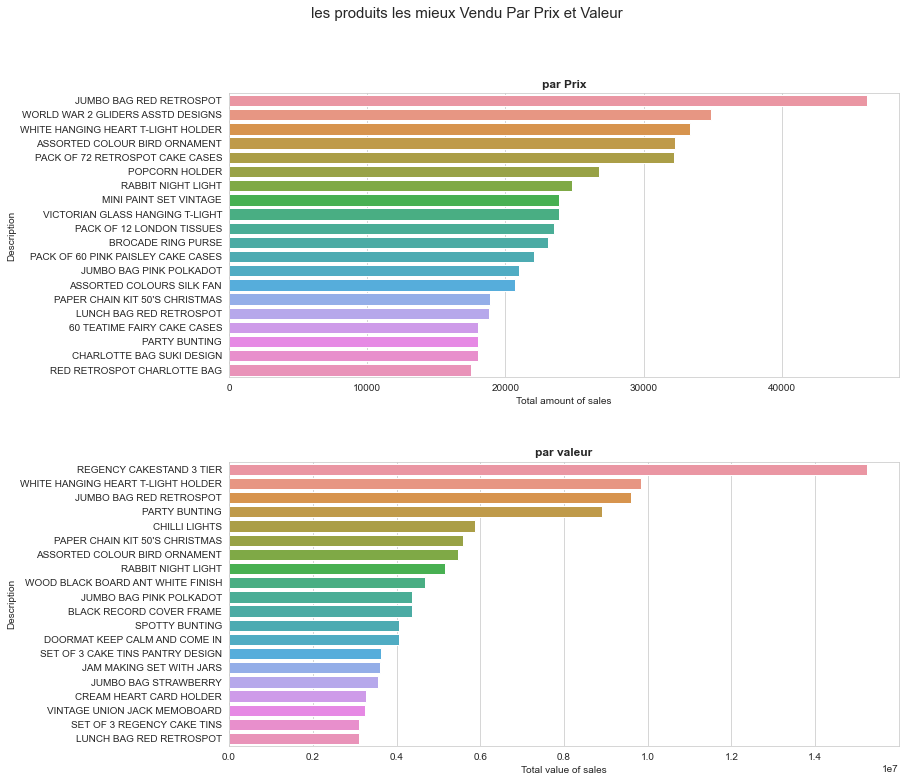

In [14]:
#importing necessary libraries and the cleaned dataset
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline


Data.index = pd.to_datetime(Data.index, format = '%Y-%m-%d %H:%M')
#top 20 products by quantity and finalprice
sns.set_style('whitegrid')
Top20Quan = Data.groupby('Description')['Quantity'].agg('sum').sort_values(ascending=False)[0:20]
Top20Price = Data.groupby('Description')['FinalPrice'].agg('sum').sort_values(ascending=False)[0:20]
#creating the subplot
fig,axs = plt.subplots(nrows=2, ncols=1, figsize = (12,12))
plt.subplots_adjust(hspace = 0.3)
fig.suptitle('les produits les mieux Vendu Par Prix et Valeur', fontsize=15, x = 0.4, y = 0.98)
sns.barplot(x=Top20Quan.values, y=Top20Quan.index, ax= axs[0]).set(xlabel='Total amount of sales')
axs[0].set_title('par Prix', size=12, fontweight = 'bold')
sns.barplot(x=Top20Price.values, y=Top20Price.index, ax= axs[1]).set(xlabel='Total value of sales')
axs[1].set_title('par valeur', size=12, fontweight = 'bold')
plt.show()

In [15]:
# Lors d’une dépense, quel est le montant dépensé par un client
#généralement ? Tracez la distribution associée. Faîtes apparaître le montant
#moyen et le montant médian d’un panier client, par pays.

In [16]:
InvoiceNb=Data["InvoiceNo"][:10000]
FinalPrice=Data["FinalPrice"][:10000]

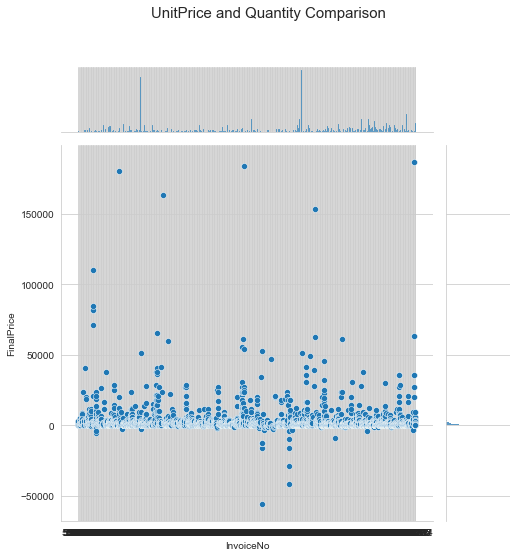

In [17]:
Corr = sns.jointplot(x=InvoiceNb, y=FinalPrice, data = FinalPrice>0, height = 7)
Corr.fig.suptitle("UnitPrice and Quantity Comparison", fontsize = 15, y = 1.1)
plt.show()

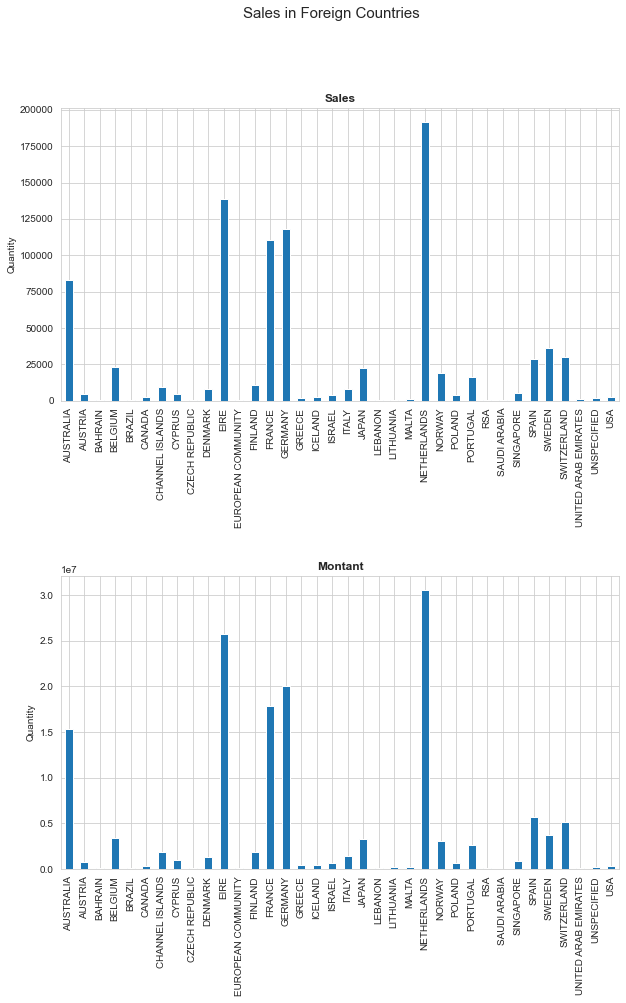

In [18]:
#grouping data by the countries(except UK)
ByCountrySale = Data[(Data.Country != 'UNITED KINGDOM') & (Data.Quantity > 0)].groupby('Country')['Quantity'].sum()
ByMontant = Data[(Data.Country != 'UNITED KINGDOM') & (Data.Quantity > 0)].groupby('Country')['FinalPrice'].sum().abs()
#creating the subplot
fig, [ax1,ax2] = plt.subplots(nrows=2,ncols=1,figsize=(10,14))
ByCountrySale.plot(kind='bar', ax=ax1).set(ylabel = 'Quantity',xlabel='')
ax1.set_title('Sales', size=12, fontweight = 'bold')
ByMontant.plot(kind='bar', ax=ax2).set(ylabel = 'Quantity',xlabel='')
ax2.set_title('Montant', size=12, fontweight = 'bold')
plt.suptitle('Sales in Foreign Countries', fontsize = 15)
plt.subplots_adjust(hspace = 0.6)
plt.show()

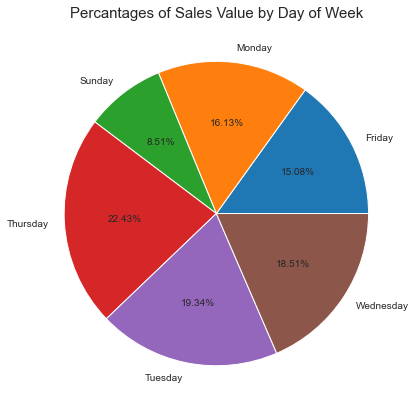

In [19]:
#creating the pie chart
Data.groupby('Day of week')['FinalPrice'].sum().plot(kind = 'pie', autopct = '%.2f%%', figsize=(7,7)).set(ylabel='')
plt.title('Percantages of Sales Value by Day of Week', fontsize = 15)
plt.show()

In [20]:
Data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FinalPrice,InvoiceMonth,Day of week
1970-01-01 00:00:00.000000000,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,295.0,17850.0,UNITED KINGDOM,1770.0,December,Wednesday
1970-01-01 00:00:00.000000001,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,375.0,17850.0,UNITED KINGDOM,2250.0,December,Wednesday
1970-01-01 00:00:00.000000002,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,415.0,17850.0,UNITED KINGDOM,3320.0,December,Wednesday
1970-01-01 00:00:00.000000003,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,375.0,17850.0,UNITED KINGDOM,2250.0,December,Wednesday
1970-01-01 00:00:00.000000004,536365,84029E,RED WOOLLY HOTTIE WHITE HEART,6,2010-12-01 08:26:00,425.0,17850.0,UNITED KINGDOM,2550.0,December,Wednesday


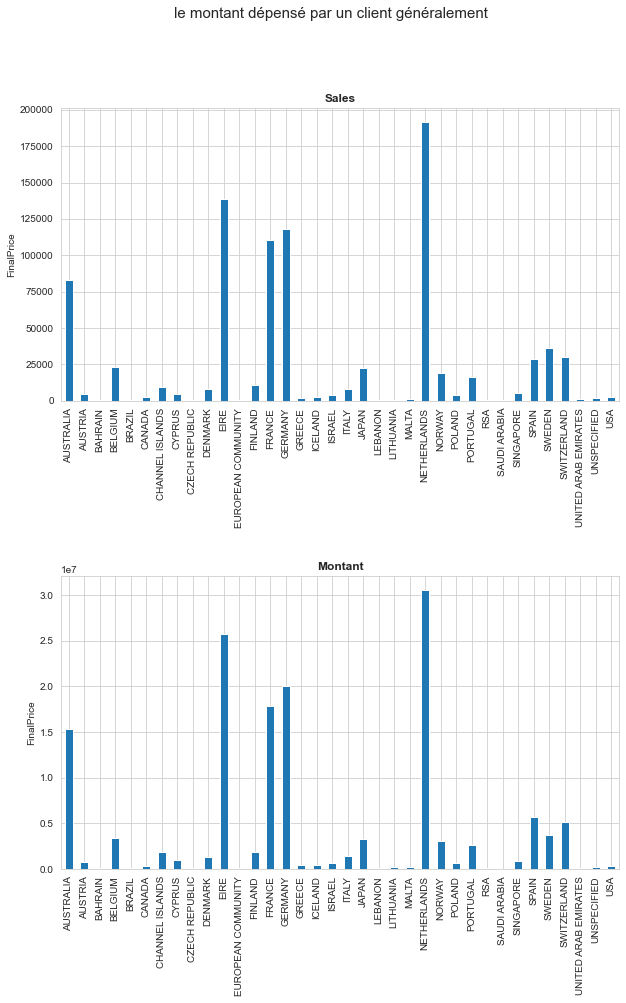

In [21]:
#grouping data by the countries(except UK)
ByCountrySale = Data[(Data.Country != 'UNITED KINGDOM') & (Data.Quantity > 0)].groupby('Country')['Quantity'].sum()
ByMontant = Data[(Data.Country != 'UNITED KINGDOM') & (Data.FinalPrice > 0)].groupby('Country')['FinalPrice'].sum().abs()
#creating the subplot
fig, [ax1,ax2] = plt.subplots(nrows=2,ncols=1,figsize=(10,14))
ByCountrySale.plot(kind='bar', ax=ax1).set(ylabel = 'FinalPrice',xlabel='')
ax1.set_title('Sales', size=12, fontweight = 'bold')
ByMontant.plot(kind='bar', ax=ax2).set(ylabel = 'FinalPrice',xlabel='')
ax2.set_title('Montant', size=12, fontweight = 'bold')
plt.suptitle('le montant dépensé par un client généralement', fontsize = 15)
plt.subplots_adjust(hspace = 0.6)
plt.show()

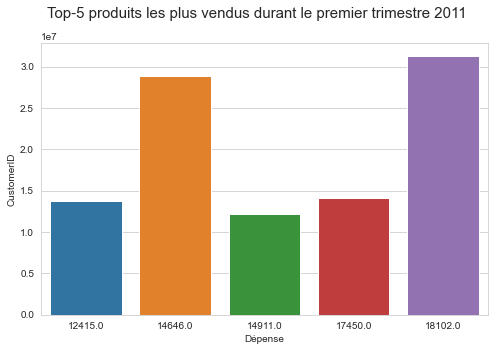

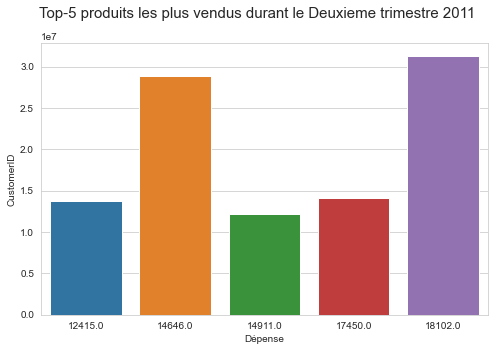

In [22]:
#Quels sont les top-5 produits les plus vendus durant le premier trimestre 2011 ? Pendant le second trimestre 2011 ?
Data_sup_2011=Data[(Data.InvoiceDate>"01/01/2011")]
Top5Clients = Data_sup_2011.groupby(['CustomerID','Country'])['FinalPrice'].sum().sort_values(ascending=False)[1:6]
Top5Clients=pd.DataFrame(Top5Clients).reset_index()
#creating the barplot
plt.figure(figsize=(8,5))
sns.barplot(x=Top5Clients.CustomerID, y=Top5Clients.FinalPrice).set(xlabel='Dépense',ylabel='CustomerID')
plt.suptitle('Top-5 produits les plus vendus durant le premier trimestre 2011', fontsize = 15)
plt.show()



Data_sup_2011=Data[(Data.InvoiceDate>"01/04/2011")]
Top5Clients = Data_sup_2011.groupby(['CustomerID','Country'])['FinalPrice'].sum().sort_values(ascending=False)[1:6]
Top5Clients=pd.DataFrame(Top5Clients).reset_index()
#creating the barplot
plt.figure(figsize=(8,5))
sns.barplot(x=Top5Clients.CustomerID, y=Top5Clients.FinalPrice).set(xlabel='Dépense',ylabel='CustomerID')
plt.suptitle('Top-5 produits les plus vendus durant le Deuxieme trimestre 2011', fontsize = 15)
plt.show()

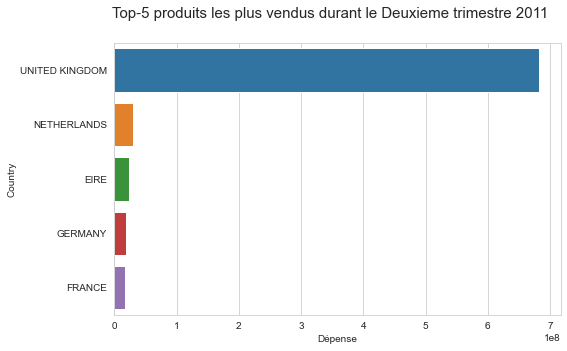

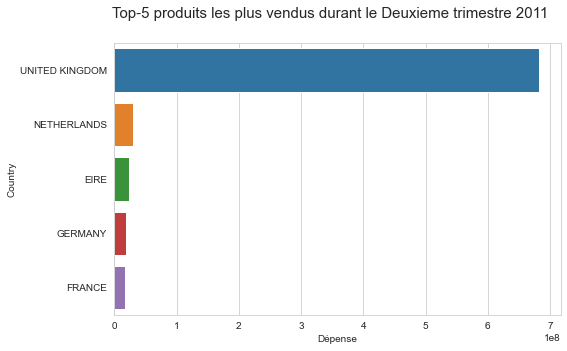

In [23]:
#filtering customers by the total finalprice
Data_sup_2011=Data[(Data.InvoiceDate>"01/01/2011")]
Top05Pays = Data_sup_2011.groupby(['Country'])['FinalPrice'].sum().sort_values(ascending=False)[0:5]
#creating the barplot
plt.figure(figsize=(8,5))
sns.barplot(x=Top05Pays.values, y=Top05Pays.index).set(xlabel='Dépense',ylabel='Country')
plt.suptitle('Top-5 produits les plus vendus durant le Deuxieme trimestre 2011', fontsize = 15)
plt.show()

Data_sup_2011=Data[(Data.InvoiceDate>"01/04/2011")]
Top05Pays = Data_sup_2011.groupby(['Country'])['FinalPrice'].sum().sort_values(ascending=False)[0:5]
#creating the barplot
plt.figure(figsize=(8,5))
sns.barplot(x=Top05Pays.values, y=Top05Pays.index).set(xlabel='Dépense',ylabel='Country')
plt.suptitle('Top-5 produits les plus vendus durant le Deuxieme trimestre 2011', fontsize = 15)
plt.show()



C:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


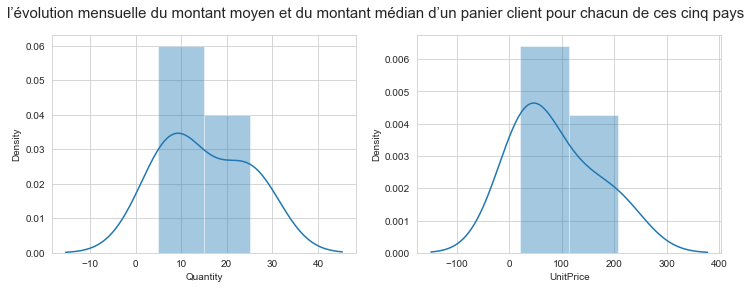

In [24]:
fig , [ax1,ax2] = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
Data_sup_2011=Data[(Data.InvoiceDate>"01/01/2011")][:5]
with sns.axes_style('dark'):
    sns.distplot(Data_sup_2011['Quantity'], ax=ax1)
    sns.distplot(Data_sup_2011['UnitPrice'], ax=ax2)
fig.suptitle('l’évolution mensuelle du montant moyen et du montant médian d’un panier client pour chacun de ces cinq pays', fontsize = 15)
plt.show();

C:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


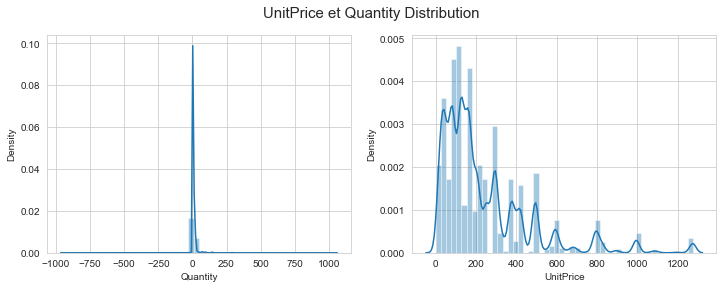

In [25]:
#creating distribution plots
fig , [ax1,ax2] = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
with sns.axes_style('dark'):
    sns.distplot(Data['Quantity'], ax=ax1)
    sns.distplot(Data['UnitPrice'], ax=ax2)
fig.suptitle('UnitPrice et Quantity Distribution', fontsize = 15)
plt.show()


In [32]:
Data.groupby("CustomerID").sum().reset_index().sort_values(by="FinalPrice",ascending=False).head(10)

,CustomerID,Quantity,UnitPrice,FinalPrice
0,0.0,404453,25824151.0,72435277.0
4215,18102.0,63836,234153.0,34954811.0
1696,14646.0,188074,424694.0,30115714.0
3742,17450.0,57795,101777.0,14344953.0
55,12415.0,75702,193240.0,13742536.0
1888,14911.0,76778,1638610.0,12783962.0
1338,14156.0,55348,409193.0,11530115.0
3785,17511.0,63011,273625.0,10544959.0
998,13694.0,57856,111257.0,7669862.0
3189,16684.0,49391,73024.0,7467171.0


In [26]:
#importing necessary libraries and the dataset
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
%matplotlib inline

In [163]:
df=Data.reset_index()

In [164]:
df.corr()

,Quantity,UnitPrice,CustomerID,FinalPrice
Quantity,1.000000,-0.098200,0.116117,0.665894
UnitPrice,-0.098200,1.000000,0.075625,0.124665
CustomerID,0.116117,0.075625,1.000000,0.088112
FinalPrice,0.665894,0.124665,0.088112,1.000000


In [165]:
df["Country"].unique()

array(['UNITED KINGDOM', 'FRANCE', 'AUSTRALIA', 'NETHERLANDS', 'GERMANY',
       'NORWAY', 'EIRE', 'SWITZERLAND', 'SPAIN', 'POLAND', 'PORTUGAL',
       'ITALY', 'BELGIUM', 'LITHUANIA', 'JAPAN', 'ICELAND',
       'CHANNEL ISLANDS', 'DENMARK', 'CYPRUS', 'SWEDEN', 'AUSTRIA',
       'ISRAEL', 'FINLAND', 'GREECE', 'SINGAPORE', 'LEBANON',
       'UNITED ARAB EMIRATES', 'SAUDI ARABIA', 'CZECH REPUBLIC', 'CANADA',
       'UNSPECIFIED', 'BRAZIL', 'USA', 'EUROPEAN COMMUNITY', 'BAHRAIN',
       'MALTA', 'RSA'], dtype=object)

In [166]:
#on peut voir que la forte relation entre les variables c'est entre Quantité et le prix final ou les dépense du coup on peux dire que le variable quantité à un poids dans notre probleme 


Text(0.5, 1.0, 'Time-Series plot for France')

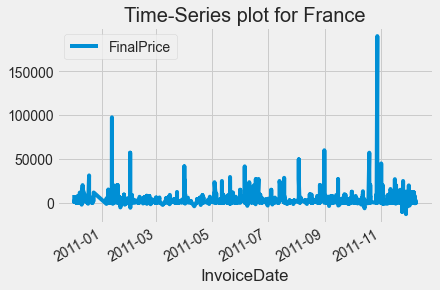

In [167]:
def time_series(country):
    dataset = df[df['Country'] == country]
    dataset.plot(x = 'InvoiceDate', y = 'FinalPrice')
  
  
time_series('FRANCE')
plt.title('Time-Series plot for France', fontsize = 20)

In [168]:
df.set_index("InvoiceDate").head()

,index,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,FinalPrice,InvoiceMonth,Day of week
InvoiceDate,,,,,,,,,,,
2010-12-01 08:26:00,1970-01-01 00:00:00.000000000,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,295.0,17850.0,UNITED KINGDOM,1770.0,December,Wednesday
2010-12-01 08:26:00,1970-01-01 00:00:00.000000001,536365,71053,WHITE METAL LANTERN,6,375.0,17850.0,UNITED KINGDOM,2250.0,December,Wednesday
2010-12-01 08:26:00,1970-01-01 00:00:00.000000002,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,415.0,17850.0,UNITED KINGDOM,3320.0,December,Wednesday
2010-12-01 08:26:00,1970-01-01 00:00:00.000000003,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,375.0,17850.0,UNITED KINGDOM,2250.0,December,Wednesday
2010-12-01 08:26:00,1970-01-01 00:00:00.000000004,536365,84029E,RED WOOLLY HOTTIE WHITE HEART,6,425.0,17850.0,UNITED KINGDOM,2550.0,December,Wednesday


In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [129]:
#df_.index = pd.to_datetime(df.InvoiceDate)


In [170]:
#librairies de data viz
import matplotlib.pyplot as plt
import seaborn as sns
# librairies des modèle linéaire
from sklearn import linear_model
#librairie des modèle d'ensemble 
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
# librairies des métriques
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
# librairies pour le k-fold cross validation
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

In [254]:
df_France=df[df['Country']=="FRANCE"]
#df_France = pd.get_dummies(df, columns=['Country'], prefix = ['Country'])
#df_France=df_France.reset_index()
#df_France = pd.get_dummies(df_France, columns=['Country'], prefix = ['Country'])
X = df.drop(['index', 'FinalPrice'], axis=1)
y=df_France[["FinalPrice"]]

In [255]:
#X = X["InvoiceDate"].values.astype('datetime64[D]')

In [256]:
#df_France['InvoiceDate'] = pd.to_datetime(df_France['InvoiceDate'], format="%Y-%m-%d")

In [257]:
#df_France=df_France.drop(["index"],axis=1)

In [258]:

X = df_France.drop(["FinalPrice",'Day of week', 'InvoiceMonth',"InvoiceDate","InvoiceNo","CustomerID","StockCode","Description","Country"], axis=1)
y = df_France[['FinalPrice']]

In [270]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)  #phase d’apprentissage
print(lr.score(X_train, y_train))
print(lr.score(X_test,y_test))

0.7394723972357777
0.45343865112869297


In [271]:
l = linear_model.Lasso()
l.fit(X_train, y_train)  #phase d’apprentissage
predl = l.predict(X_test)
scorel=r2_score(y_test,predl)
scorel

0.4534435902226719

In [272]:
r = linear_model.Ridge()
r.fit(X_train, y_train)  #phase d’apprentissage
predr = r.predict(X_test)
scorer=r2_score(y_test,predr)
scorer

0.45343879029945133

In [273]:
lr = linear_model.LinearRegression()

scores = cross_val_score(lr, X, y, cv=5)

print("score",scores)

print("moyenne :%0.03f , deviation: :%0.03f" % (scores.mean(), scores.std()))

score [0.68355142 0.47521899 0.59909694 0.74007571 0.26109508]
moyenne :0.552 , deviation: :0.171


In [274]:
from sklearn.ensemble import RandomForestRegressor

# Define the model. Set random_state to 1
rf_model = RandomForestRegressor()

# fit your model
rf_model.fit(X_train, y_train)
rf_model.score(X_train, y_train)

<ipython-input-274-21d61bdef51f>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


0.9816562055431122

In [275]:
rf = RandomForestRegressor()

scores = cross_val_score(rf, X, y, cv=5)

print("score",scores)

print("moyenne :%0.03f , deviation: :%0.03f" % (scores.mean(), scores.std()))

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

score [0.877984   0.94653337 0.97161521 0.79399574 0.94674166]
moyenne :0.907 , deviation: :0.065


In [276]:
rf_model = RandomForestRegressor(n_estimators=5, max_depth=5)

# fit your model
rf_model.fit(X_train, y_train)
print(rf_model.score(X_train, y_train))
print(rf_model.score(X_test, y_test))

0.8913183119166214
0.728447106010268


<ipython-input-276-01615b3c2f11>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


In [284]:
#df_France['InvoiceDate'] = pd.to_datetime(df_France['InvoiceDate'], format="%Y-%m-%d")

In [285]:
df_France.head()

,index,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,FinalPrice,InvoiceMonth,Day of week
InvoiceDate,,,,,,,,,,,
2010-12-01 08:45:00,1970-01-01 00:00:00.000000026,536370,22728,ALARM CLOCK BAKELIKE PINK,24,375.0,12583.0,FRANCE,9000.0,December,Wednesday
2010-12-01 08:45:00,1970-01-01 00:00:00.000000027,536370,22727,ALARM CLOCK BAKELIKE RED,24,375.0,12583.0,FRANCE,9000.0,December,Wednesday
2010-12-01 08:45:00,1970-01-01 00:00:00.000000028,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,375.0,12583.0,FRANCE,4500.0,December,Wednesday
2010-12-01 08:45:00,1970-01-01 00:00:00.000000029,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,85.0,12583.0,FRANCE,1020.0,December,Wednesday
2010-12-01 08:45:00,1970-01-01 00:00:00.000000030,536370,21883,STARS GIFT TAPE,24,65.0,12583.0,FRANCE,1560.0,December,Wednesday


In [287]:
from sklearn.model_selection import train_test_split

x=df_France[["UnitPrice","Quantity"]]
y=df_France["FinalPrice"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.1,random_state = 0)

In [289]:
lr = LinearRegression()
lr.fit(x_train,y_train)
lr.score(x_test,y_test)

0.7986219794892564

# Predict

In [294]:
Test_data = [[2011.12,01.2011]]
prediction = lr.predict(Test_data)

C:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [295]:
print(prediction)

[9634.51909207]
